# Data Curation & Setup

This notebook works through data collection, curation, and conversion to HuggingFace Dataset object.

We will be working with the [Wiki Neutrality Corpus (WNC)](https://arxiv.org/pdf/1911.09709.pdf) - a parallel corpus of 180,000 biased and neutralized sentence pairs along with contextual sentences and metadata. The corpus was harvested from Wikipedia edits that were designed to ensure texts had a neutral point of view. WNC is the first parallel corpus of biased language.

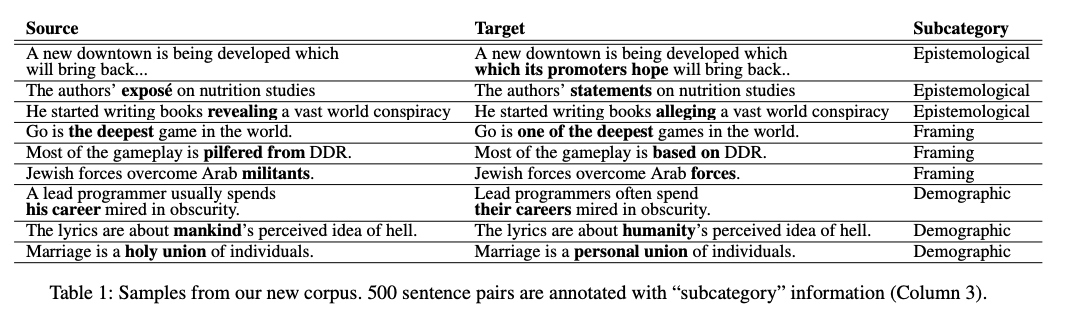

The Wiki Neutrality Corpus consists of aligned sentences pre and post-neutralization by English Wikipedia editors (Table 1). We used regular expressions to crawl 423,823 Wikipedia revisions between 2004 and 2019 where editors provided neutral point of view (NPOV)-related justification.

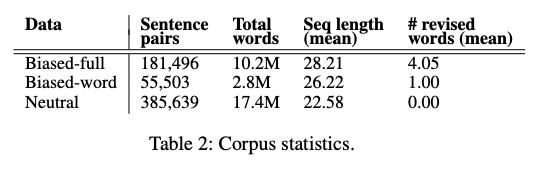

## Download Data

In [4]:
!curl -L http://nlp.stanford.edu/projects/bias/bias_data.zip -o ~/data/raw/bias_data.zip
!unzip ~/data/raw/bias_data.zip -d ~/data/raw/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   318    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  104M  100  104M    0     0  51.5M      0  0:00:02  0:00:02 --:--:-- 52.0M


## Inspect Data

In [1]:
from tqdm import tqdm

In [2]:
DATA_PATH = "/home/cdsw/data/raw/bias_data/WNC/biased.word.dev"

In [3]:
collect = []

for i, line in enumerate(tqdm(open(DATA_PATH))):
    parts = line.strip().split('\t')
    collect.append(parts)
    if i ==5:
        break
    

5it [00:00, 16683.79it/s]


In [4]:
for rev in collect:
    print('REV_ID: ', rev[0])
    print()
    print('PRE-TOKEN: ', rev[1])
    print('POST-TOKEN: ', rev[2])
    print()
    print('PRE: ', rev[3])
    print('POST: ', rev[4])
    print()
    print()
    print('POS: ', rev[5])
    print('RELATIONS: ', rev[6])
    print('------------------------------------------------------------------------------------------')

REV_ID:  3257810

PRE-TOKEN:  in addition to sponsoring palestinian terror attacks against israel ( often through jordanian territory , much to king hussein ' s cha ##grin ) , syria also began shell ##ing of israeli civilian communities in north - eastern galilee , from gun em ##pl ##ace ##ments on the syrian - controlled go ##lan heights .
POST-TOKEN:  in addition to sponsoring palestinian attacks against israel ( often through jordanian territory , much to king hussein ' s cha ##grin ) , syria also began shell ##ing of israeli civilian communities in north - eastern galilee , from gun em ##pl ##ace ##ments on the syrian - controlled go ##lan heights .

PRE:  in addition to sponsoring palestinian terror attacks against israel (often through jordanian territory, much to king hussein's chagrin), syria also began shelling of israeli civilian communities in north-eastern galilee, from gun emplacements on the syrian-controlled golan heights.
POST:  in addition to sponsoring palestinian att

## Let's Inspect a Pre-built seq2seq Dataset

In [5]:
from datasets import load_dataset

In [6]:
raw_datasets = load_dataset("kde4", lang1="en", lang2="fr")

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset kde4 (/home/cdsw/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
raw_datasets['train'].features

{'id': Value(dtype='string', id=None),
 'translation': Translation(languages=['en', 'fr'], id=None)}

In [8]:
raw_datasets['train'].description

'A parallel corpus of KDE4 localization files (v.2).\n\n92 languages, 4,099 bitexts\ntotal number of files: 75,535\ntotal number of tokens: 60.75M\ntotal number of sentence fragments: 8.89M\n'

In [9]:
raw_datasets['train'].features

{'id': Value(dtype='string', id=None),
 'translation': Translation(languages=['en', 'fr'], id=None)}

In [10]:
raw_datasets['train'][17]['translation']

{'en': 'Not all languages are available from the Babelfish service.',
 'fr': 'Toutes les langues ne sont pas disponibles à partir du service Babelfish.'}

In [11]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

## Format WNC Biased-word Data as HuggingFace Dataset

We'll start by working with the smaller "Biased-word" dataset used in the reference paper. Let's prepare the dataset by formatting it as a HuggingFace DatasetDict object.

In [12]:
%load_ext lab_black

In [13]:
import os
import torch
from collections import defaultdict
from datasets import load_dataset, Dataset, DatasetDict, Value, Translation, Features


def build_hf_dataset(path: str) -> DatasetDict:
    """
    Formats the raw biased-word data into HuggingFace DatasetDict object.

    Provided a path to the raw Wiki Neutrality Corpus (WNC) data files, this function parses
    each of the dev, test, and train sets and formats them as a HuggingFace DatasetDict object
    in the seq2seq style (i.e. ready for translation tasks).

    https://arxiv.org/pdf/1911.09709.pdf

    Args:
        path (str): path to directory containing raw WNC data files

    Returns:
        DatasetDict

    """

    splits = ["dev", "test", "train"]
    dataset_dict = defaultdict(dict)

    FEATURES = Features(
        {
            "rev_id": Value("string"),
            "translation": Translation(languages=["pre", "post"]),
        }
    )

    for split in splits:

        PATH = os.path.join(path, f"biased.word.{split}")

        rev_ids = []
        translation_pairs = []

        for i, line in enumerate(tqdm(open(PATH))):
            parts = line.strip().split("\t")

            # note some entries contain the POS and REL fields, others dont
            if len(parts) == 7:
                rev_id, pre_tok, post_tok, pre_raw, post_raw, pos, rels = parts

            elif len(parts) == 5:
                rev_id, pre_tok, post_tok, pre_raw, post_raw = parts

            else:
                print(f"Skipped entry: {i}")

            rev_ids.append(rev_id)
            translation_pairs.append({"pre": pre_raw, "post": post_raw})

        split_dict = {
            "rev_id": rev_ids,
            "translation": translation_pairs,
        }

        dataset_dict[split] = Dataset.from_dict(split_dict, features=FEATURES)

    return DatasetDict(dataset_dict)

In [14]:
DATA_PATH = "/home/cdsw/data/raw/bias_data/WNC"

wnc_datasets = build_hf_dataset(DATA_PATH)

700it [00:00, 64155.51it/s]
1000it [00:00, 108593.21it/s]
53803it [00:00, 142996.82it/s]


In [15]:
wnc_datasets

DatasetDict({
    dev: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 700
    })
    test: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 53803
    })
})

## EDA on WNC Biased-Word Datasets